# Lab08: Cross Validation & Ensembling
<hr>

110062802 呂宸漢


## 1. Data Preprocessing


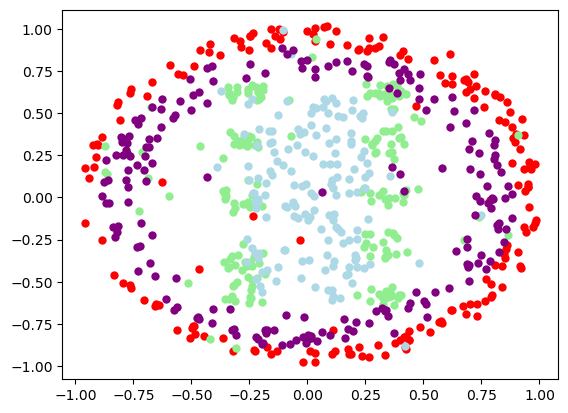

In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}

df_train = pd.read_csv('./train.csv')
X_train = df_train.drop(columns=['Competitor']).values
y_train = df_train['Competitor'].map(y_mapping).values

df_test = pd.read_csv('./test.csv')
X_test = df_test.drop(columns=['Competitor']).values
y_test = df_test['Competitor'].map(y_mapping).values

plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            label='Bob', c='red', linewidths=0)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            label='Kate', c='lightgreen', linewidths=0)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1],
            label='Mark', c='lightblue', linewidths=0)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1],
            label='Sue', c='purple', linewidths=0)
plt.show()


## 2. Model Evaluation


In [2]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True, random_state=0)


### Logistic Regression


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe_lr = Pipeline([('poly', PolynomialFeatures()),
                    ('sc', StandardScaler()),
                    ('clf', LogisticRegression(random_state=0))])

param_gird = {'poly__degree': [1, 2, 3],
              'clf__C': range(1, 20),
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
gs = GridSearchCV(estimator=pipe_lr, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[Logistic Regression]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

best_lr = gs.best_estimator_


[Logistic Regression]
best params {'clf__C': 9, 'clf__solver': 'newton-cg', 'poly__degree': 2}
accuracy-train = 0.860, accuracy-test = 0.816


### K-Nearest Neighbors Classifier

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe_knn = Pipeline([('sc', StandardScaler()),
                     ('clf', KNeighborsClassifier())])

param_gird = {'clf__n_neighbors': range(1, 20),
              'clf__p': [1, 2]}
gs = GridSearchCV(estimator=pipe_knn, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[K-Nearest Neighbors Classifier]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

best_knn = gs.best_estimator_


[K-Nearest Neighbors Classifier]
best params {'clf__n_neighbors': 3, 'clf__p': 1}
accuracy-train = 0.904, accuracy-test = 0.784


### Decision Tree Classifier


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(random_state=0)

param_gird = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': range(1, 20)}
gs = GridSearchCV(estimator=tree, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[Decision Tree Classifier]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))

best_tree = gs.best_estimator_


[Decision Tree Classifier]
best params {'criterion': 'entropy', 'max_depth': 7}
accuracy-train = 0.886, accuracy-test = 0.768


### Random Forest Classifier


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(random_state=0)

param_gird = {'n_estimators': [50, 100, 250, 500, 750, 1000],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': range(1, 20, 2)}
gs = GridSearchCV(estimator=forest, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[Random Forest Classifier]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


[Random Forest Classifier]
best params {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 750}
accuracy-train = 1.000, accuracy-test = 0.805


### Voting Classifier


In [7]:
from sklearn.ensemble import VotingClassifier
from itertools import product
from sklearn.model_selection import GridSearchCV

voting = VotingClassifier(estimators=[('lr', best_lr),
                                      ('knn', best_knn),
                                      ('tree', best_tree)],
                          n_jobs=-1)

param_gird = {'weights': list(product(range(0, 3), range(0, 3), range(0, 3)))}
gs = GridSearchCV(estimator=voting, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[Voting Classifier]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


[Voting Classifier]
best params {'weights': (2, 1, 2)}
accuracy-train = 0.907, accuracy-test = 0.827


### Bagging Classifier


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

bagging = BaggingClassifier(base_estimator=best_tree, random_state=0)

param_gird = {'base_estimator__max_depth': range(1, 20, 2),
              'n_estimators': [50, 100, 250, 500, 750, 1000],
              'max_samples': [0.1, 0.3, 0.5, 0.7, 1.0]}
gs = GridSearchCV(estimator=bagging, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[Bagging Classifier]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


[Bagging Classifier]
best params {'base_estimator__max_depth': 9, 'max_samples': 1.0, 'n_estimators': 750}
accuracy-train = 0.950, accuracy-test = 0.805


### AdaBoost Classifier


* decision tree with depth = 1

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(max_depth=1, random_state=0)
adaBoost = AdaBoostClassifier(base_estimator=tree, random_state=0)

param_gird = {'base_estimator__criterion': ['gini', 'entropy', 'log_loss'],
              'n_estimators': range(100, 1000, 50)}
gs = GridSearchCV(estimator=adaBoost, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[AdaBoost Classifier (max_depth = 1)]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


[AdaBoost Classifier (max_depth = 1)]
best params {'base_estimator__criterion': 'gini', 'n_estimators': 150}
accuracy-train = 0.614, accuracy-test = 0.508


* decision tree with depth > 1

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

adaBoost = AdaBoostClassifier(base_estimator=best_tree, random_state=0)

param_gird = {'base_estimator__max_depth': range(3, 20, 2),
              'n_estimators': [50, 100, 250, 500, 750, 1000]}
gs = GridSearchCV(estimator=adaBoost, param_grid=param_gird,
                  scoring='accuracy', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print('[AdaBoost Classifier (max_depth > 1)]')
print('best params', gs.best_params_)
print('accuracy-train = %.3f, accuracy-test = %.3f' %
      (gs.score(X_train, y_train), gs.score(X_test, y_test)))


[AdaBoost Classifier (max_depth > 1)]
best params {'base_estimator__max_depth': 9, 'n_estimators': 100}
accuracy-train = 1.000, accuracy-test = 0.811


## 3. Summary

每個model我都有用`GridSearch`尋找好的hyper parameter設定並用10-fold cross validation驗證(詳細的`param_grid`設定請見notebook)。下表是我用`GridSearch`後用`best_estimator_`預測的結果，可以看到ensemble model (Random Forest, Voting, Bagging, AdaBoost)可以很好的fit training data並在預測testing data上有很不錯的結果，其中又以Voting表現最佳。Bagging跟AdaBoost的`base_estimator`我都採用Decision Tree，Voting的`estimators`我則使用Logistic Regression、K-Nearest Neighbors和Decision Tree的`best_estimator_`以提供較好的base。而Logistic Regression則是在使用`PolynomialFeatures(degree=2)`將feature擴大後可以得到與ensemble model相近的結果。

值得一提的是AdaBoost在`base_estimator`的`max_depth = 1`時再利用`GridSearch`也找不到好的參數，training跟testing的結果都很差，而在`max_depth = 1`時再利用`GridSearch`則有很好的效果。由此實驗我推斷boost的技術雖然可以利用其他的estimator補足原先的不足，可是base estimator如果很差的話，boost也做不到很好的結果。

| Model | Training Accuracy (%) | Testing Accuracy (%) |
| :---: | :---: | :---: |
| Logistic Regression | 0.860 | 0.816 |
| K-Nearest Neighbors Classifier | 0.904 | 0.784 |
| Decision Tree Classifier | 0.886 | 0.768 |
| Random Forest Classifier | 1.000 | 0.805 |
| Voting Classifier | 0.907 | 0.827 |
| Bagging Classifier | 0.950 | 0.805 |
| AdaBoost Classifier (max_depth = 1) | 0.614 | 0.508 |
| AdaBoost Classifier (max_depth > 1) | 1.000 | 0.811 |
